## National Water Model Example

As described in the [overview](https://planetarycomputer.microsoft.com/dataset/storage/noaa-nwm), National Water Model products are available from Azure Blob Storage. This notebook uses [xarray](https://xarray.pydata.org/) and [adlfs](https://fsspec.github.io/adlfs) to load the NetCDF files and visualize the data.

In [1]:
import azure.storage.blob
import planetary_computer
import adlfs
import pandas as pd
import geopandas
import xarray as xr

fs = adlfs.AzureBlobFileSystem(
    "noaanwm", credential=planetary_computer.sas.get_token("noaanwm", "nwm").token
)

A new set of files is produced daily, using the filepattern `nmw.YYYYMMDD` for year, month, and day.

## Streamflow data

This example shows how to load `streamflow` data and visualize it on a map.

In [2]:
prefix = "nwm/nwm.20230123"

ds = xr.open_dataset(
    fs.open(f"{prefix}/short_range/nwm.t00z.short_range.channel_rt.f001.conus.nc")
)
ds

<xarray.Dataset>
Dimensions:         (time: 1, reference_time: 1, feature_id: 2776738)
Coordinates:
  * time            (time) datetime64[ns] 2023-01-23T01:00:00
  * reference_time  (reference_time) datetime64[ns] 2023-01-23
  * feature_id      (feature_id) int32 101 179 181 ... 1180001803 1180001804
Data variables:
    crs             |S1 ...
    streamflow      (feature_id) float64 ...
    nudge           (feature_id) float64 ...
    velocity        (feature_id) float64 ...
    qSfcLatRunoff   (feature_id) float64 ...
    qBucket         (feature_id) float64 ...
    qBtmVertRunoff  (feature_id) float64 ...
Attributes: (12/19)
    TITLE:                      OUTPUT FROM NWM v2.2
    featureType:                timeSeries
    proj4:                      +proj=lcc +units=m +a=6370000.0 +b=6370000.0 ...
    model_initialization_time:  2023-01-23_00:00:00
    station_dimension:          feature_id
    model_output_valid_time:    2023-01-23_01:00:00
    ...                         ...
    model_configuration:        short_range
    dev_OVRTSWCRT:              1
    dev_NOAH_TIMESTEP:          3600
    dev_channel_only:           0
    dev_channelBucket_only:     0
    dev:                        dev_ prefix indicates development/internal me...

We can visualize the distribution of the streamflow variable:

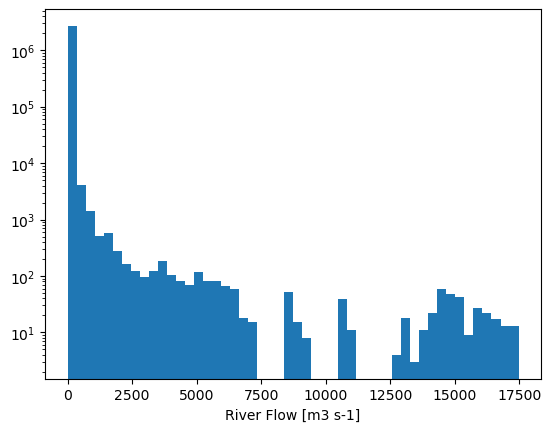

In [3]:
ds["streamflow"].plot.hist(log=True, bins=50);

The `streamflow` is indexed by a `feature_id` coordinate variable. We can load some information for those coordinates from a geoparquet file in Azure Blob Storage, created from the GeoPackage linked from https://water.noaa.gov/about/nwm.

In [4]:
gdf = geopandas.read_parquet(
    "az://hydrofabric/nwm_reaches_conus.parquet",
    storage_options={
        "account_name": "noaanwm"
    }
).set_index("ID")

The geospatial data from `gdf` can be joined to the values from `ds.streamflow`:

In [5]:
streamflow = ds.streamflow.to_pandas()
gdf["streamflow"] = streamflow
gdf.head()

Shape_Length                                           geometry  \
ID                                                                          
16746415      0.002800  MULTILINESTRING ((-80.55364 24.97691, -80.5542...   
16745403      0.004710  MULTILINESTRING ((-80.49684 25.03405, -80.4966...   
16746815      0.001640  MULTILINESTRING ((-80.56822 24.95881, -80.5668...   
16746817      0.002103  MULTILINESTRING ((-80.57308 24.95684, -80.5726...   
16746445      0.001416  MULTILINESTRING ((-80.57267 24.95478, -80.5726...   

          streamflow  
ID                    
16746415         0.0  
16745403         0.0  
16746815         0.0  
16746817         0.0  
16746445         0.0

Now we can visualize the data. Each record in `gdf` is a streamflow 

In [6]:
gdf[gdf.streamflow > 0].head(1).explore(tiles="Stamen Terrain")

To make a simple plot for the entire Continental United States, we'll take the centroid of each geometry.

In [7]:
import warnings

with warnings.catch_warnings(action="ignore"):
    center = gdf.centroid
data = pd.DataFrame({
    "x": center.x,
    "y": center.y,
    "streamflow": gdf.streamflow
})

To avoid overplotting from the 2,000,000+ points, we'll use [datashader](https://datashader.org/) to aggregate the points before plotting.

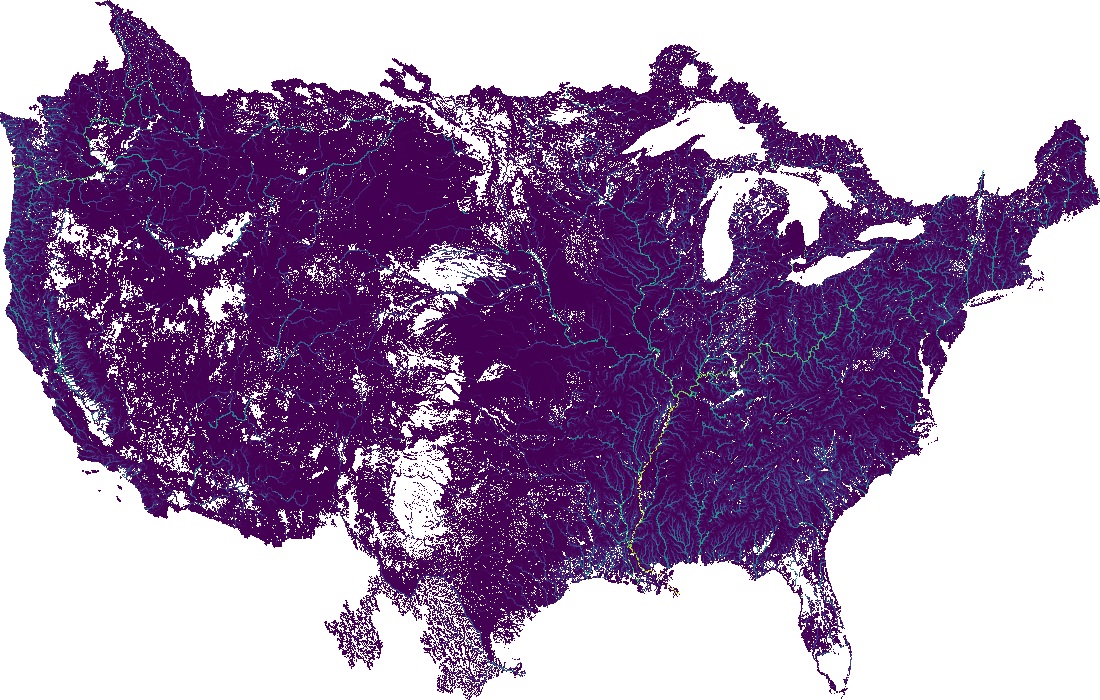

In [8]:
import datashader, colorcet
import matplotlib.pyplot as plt

viridis = plt.get_cmap("viridis")

cvs = datashader.Canvas(plot_width=1100, plot_height=700)
agg = cvs.points(data, "x", "y", agg=datashader.mean("streamflow"))
img = datashader.transfer_functions.shade(agg, how="log", cmap=viridis)
img

## Land data

We'll load a short-range `land` forecast for the Continental United States.

In [9]:
prefix = "nwm/nwm.20230123"

ds = xr.open_dataset(
    fs.open(f"{prefix}/short_range/nwm.t00z.short_range.land.f001.conus.nc")
)
display(ds)
soil_saturation = ds["SOILSAT_TOP"].load()

<xarray.Dataset>
Dimensions:         (time: 1, reference_time: 1, x: 4608, y: 3840)
Coordinates:
  * time            (time) datetime64[ns] 2023-01-23T01:00:00
  * reference_time  (reference_time) datetime64[ns] 2023-01-23
  * x               (x) float64 -2.303e+06 -2.302e+06 ... 2.303e+06 2.304e+06
  * y               (y) float64 -1.92e+06 -1.919e+06 ... 1.918e+06 1.919e+06
Data variables:
    crs             |S1 ...
    SNOWH           (time, y, x) float64 ...
    SNEQV           (time, y, x) float64 ...
    FSNO            (time, y, x) float64 ...
    ACCET           (time, y, x) float64 ...
    SOILSAT_TOP     (time, y, x) float64 ...
    SNOWT_AVG       (time, y, x) float64 ...
Attributes:
    TITLE:                      OUTPUT FROM NWM v2.2
    model_initialization_time:  2023-01-23_00:00:00
    model_output_valid_time:    2023-01-23_01:00:00
    model_total_valid_times:    18
    Conventions:                CF-1.6
    code_version:               v5.2.0-beta2
    NWM_version_number:         v2.2
    model_output_type:          land
    model_configuration:        short_range
    proj4:                      +proj=lcc +units=m +a=6370000.0 +b=6370000.0 ...
    GDAL_DataType:              Generic

The `xarray.Dataset` shows the variables that are available. We'll load the `SOILSAT_TOP` variable, which gives the fraction of soil saturation for the top two layers.

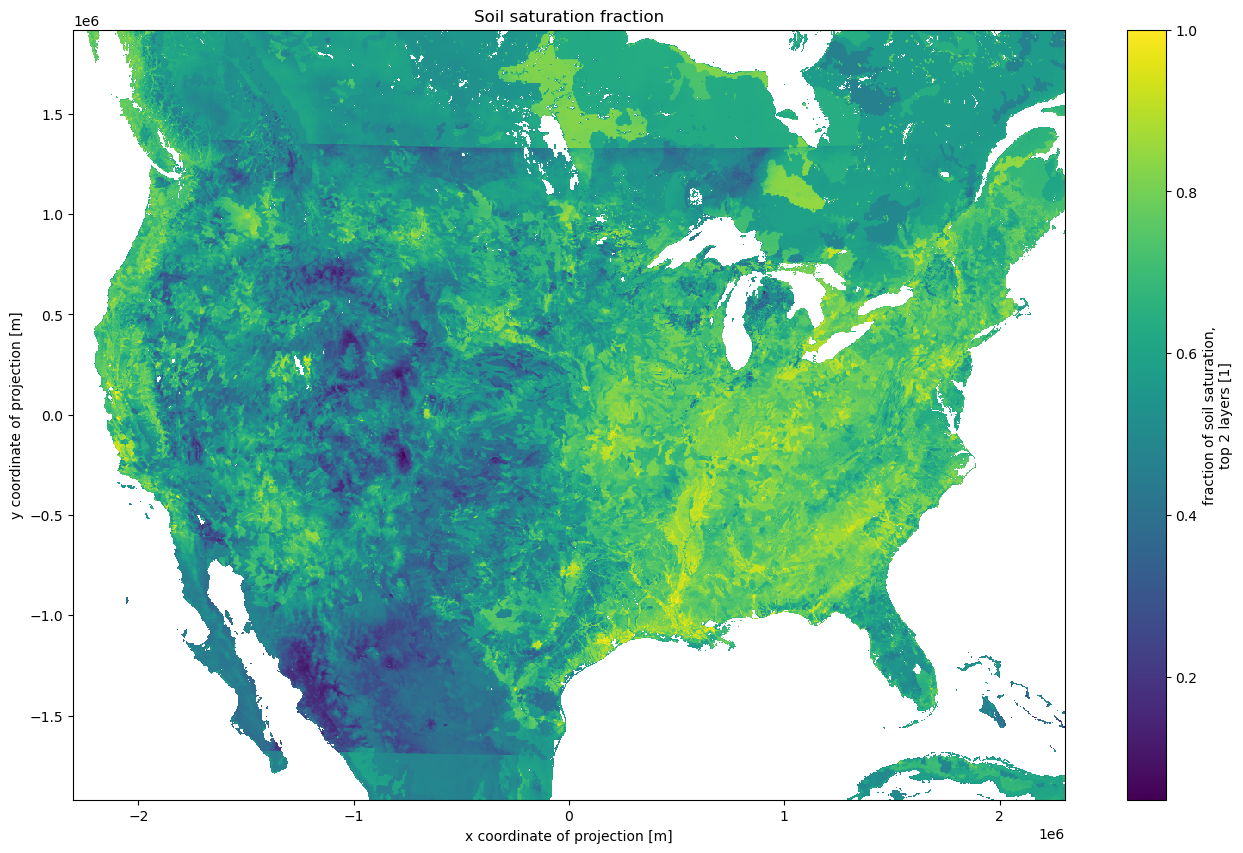

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 10))

soil_saturation.coarsen(x=4, y=4, boundary="trim").mean().plot(ax=ax)
ax.set(title="Soil saturation fraction")
plt.savefig("noaa-nwm-soil-saturation.png", bbox_inches=0, pad_inches=0)

Similar files are available for different forecast hours (`f001`, `f002`, ..., `f018`)

These forecasts also include data on channel routing, terrain routing, and reservoir output. The reservoir data can be converted from the NetCDF data model to a tabular data strcture.

In [11]:
reservoir = xr.open_dataset(
    fs.open("nwm/nwm.20230123/short_range/nwm.t00z.short_range.reservoir.f001.conus.nc")
).load()
reservoir

<xarray.Dataset>
Dimensions:                      (time: 1, reference_time: 1, feature_id: 5783)
Coordinates:
  * time                         (time) datetime64[ns] 2023-01-23T01:00:00
  * reference_time               (reference_time) datetime64[ns] 2023-01-23
  * feature_id                   (feature_id) int32 491 531 ... 1021092845
    latitude                     (feature_id) float32 46.18 46.16 ... 44.59
    longitude                    (feature_id) float32 -68.38 -68.45 ... -73.31
Data variables:
    crs                          |S1 b''
    reservoir_type               (feature_id) float64 1.0 1.0 1.0 ... 1.0 1.0
    reservoir_assimilated_value  (feature_id) float32 nan nan nan ... nan nan
    water_sfc_elev               (feature_id) float32 206.2 247.9 ... 42.85
    inflow                       (feature_id) float64 0.41 0.04 ... 352.5
    outflow                      (feature_id) float64 0.56 0.39 ... 347.0
Attributes:
    TITLE:                      OUTPUT FROM NWM v2.2
    featureType:                timeSeries
    proj4:                      +proj=lcc +units=m +a=6370000.0 +b=6370000.0 ...
    model_initialization_time:  2023-01-23_00:00:00
    station_dimension:          lake_id
    model_output_valid_time:    2023-01-23_01:00:00
    model_total_valid_times:    18
    Conventions:                CF-1.6
    code_version:               v5.2.0-beta2
    NWM_version_number:         v2.2
    model_output_type:          reservoir
    model_configuration:        short_range

In [12]:
import geopandas
import pyproj

crs = pyproj.CRS.from_cf(reservoir.crs.attrs)

df = reservoir.drop("crs").to_dataframe()
geometry = geopandas.points_from_xy(df.longitude, df.latitude, crs=crs)

gdf = geopandas.GeoDataFrame(df, geometry=geometry)
gdf.head()

reservoir_type  \
time                reference_time feature_id                   
2023-01-23 01:00:00 2023-01-23     491                    1.0   
                                   531                    1.0   
                                   747                    1.0   
                                   759                    1.0   
                                   1581                   1.0   

                                               reservoir_assimilated_value  \
time                reference_time feature_id                                
2023-01-23 01:00:00 2023-01-23     491                                 NaN   
                                   531                                 NaN   
                                   747                                 NaN   
                                   759                                 NaN   
                                   1581                                NaN   

                                                latitude  longitude  \
time                reference_time feature_id                         
2023-01-23 01:00:00 2023-01-23     491         46.183273 -68.379036   
                                   531         46.161163 -68.454887   
                                   747         46.034088 -68.064995   
                                   759         46.022385 -68.162132   
                                   1581        45.648441 -67.937202   

                                               water_sfc_elev  inflow  \
time                reference_time feature_id                           
2023-01-23 01:00:00 2023-01-23     491             206.240295    0.41   
                                   531             247.883514    0.04   
                                   747             190.345016    0.02   
                                   759             165.124863    0.00   
                                   1581            130.215378    0.76   

                                               outflow  \
time                reference_time feature_id            
2023-01-23 01:00:00 2023-01-23     491            0.56   
                                   531            0.39   
                                   747            0.12   
                                   759            0.17   
                                   1581           0.96   

                                                                 geometry  
time                reference_time feature_id                              
2023-01-23 01:00:00 2023-01-23     491         POINT (-68.37904 46.18327)  
                                   531         POINT (-68.45489 46.16116)  
                                   747         POINT (-68.06499 46.03409)  
                                   759         POINT (-68.16213 46.02238)  
                                   1581        POINT (-67.93720 45.64844)

Which can also be visualized.

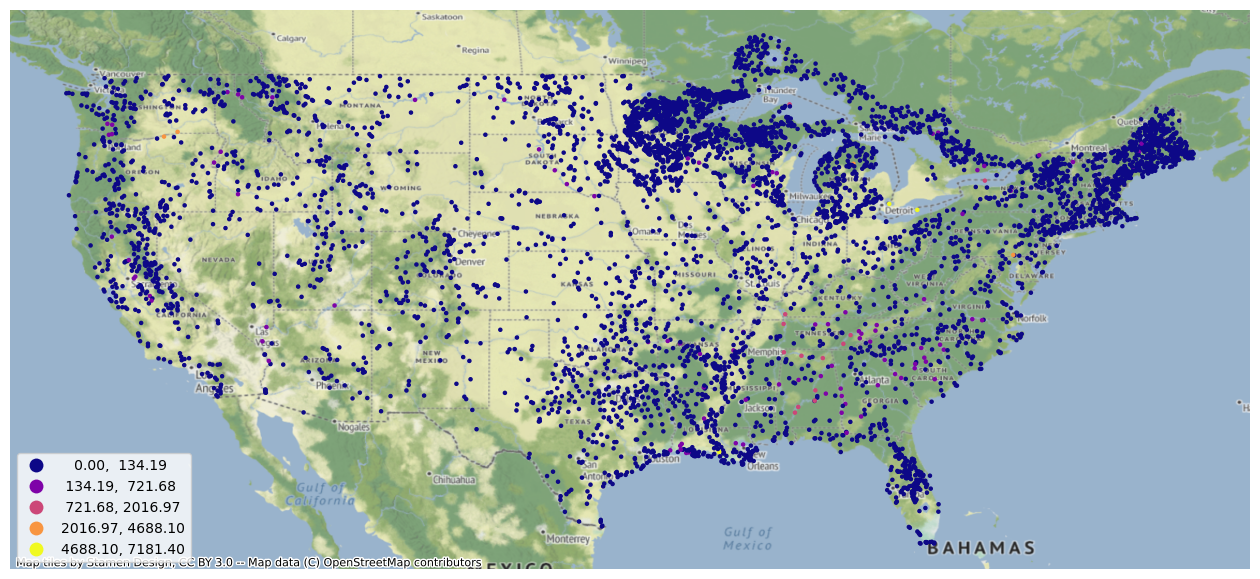

In [13]:
import contextily

fig, ax = plt.subplots(figsize=(16, 12))

gdf[["inflow", "geometry"]].plot(
    column="inflow",
    scheme="NaturalBreaks",
    markersize=5,
    legend=True,
    ax=ax,
    cmap="plasma",
)
contextily.add_basemap(ax, crs=str(gdf.crs))

ax.set_axis_off()

Other kinds data are available under each date's prefix. Some sub-folders different kinds of data (forcings, long- and medium-range forecasts, etc.) and some cover different regions (Hawaii and Puerto Rico).

In [14]:
fs.ls(prefix)

['nwm/nwm.20230123/analysis_assim',
 'nwm/nwm.20230123/analysis_assim_extend',
 'nwm/nwm.20230123/analysis_assim_extend_no_da',
 'nwm/nwm.20230123/analysis_assim_hawaii',
 'nwm/nwm.20230123/analysis_assim_hawaii_no_da',
 'nwm/nwm.20230123/analysis_assim_long',
 'nwm/nwm.20230123/analysis_assim_long_no_da',
 'nwm/nwm.20230123/analysis_assim_no_da',
 'nwm/nwm.20230123/analysis_assim_puertorico',
 'nwm/nwm.20230123/analysis_assim_puertorico_no_da',
 'nwm/nwm.20230123/forcing_analysis_assim',
 'nwm/nwm.20230123/forcing_analysis_assim_extend',
 'nwm/nwm.20230123/forcing_analysis_assim_hawaii',
 'nwm/nwm.20230123/forcing_analysis_assim_puertorico',
 'nwm/nwm.20230123/forcing_medium_range',
 'nwm/nwm.20230123/forcing_short_range',
 'nwm/nwm.20230123/forcing_short_range_hawaii',
 'nwm/nwm.20230123/forcing_short_range_puertorico',
 'nwm/nwm.20230123/long_range_mem1',
 'nwm/nwm.20230123/long_range_mem2',
 'nwm/nwm.20230123/long_range_mem3',
 'nwm/nwm.20230123/long_range_mem4',
 'nwm/nwm.20230123